<a href="https://colab.research.google.com/github/MittalNeha/Extensive_Vision_AI6/blob/main/week5/Session_5_Bhaskar_exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 5 - Step 2

## Target

    99.4% (or close to it in 20 epochs, to see if it has potential).
    See if overfitting can be reduced.
    Training accuracy reaching >99.5%, to make sure model has learning capacity.
    Less than 10000 Parameters (but target lower to have spare capacity)


## Result
    Parameter Count: 7018
    Accuracies in this run, at 15th Epoch:
    Training Accuracy(loss) : 99.495% (0.016923)
    Testing Accuracy (loss) : 99.29% (0.019708)
    In 16th Epoch we achieve 99.35% test accuracy and is the maximum in 20 Epochs. Max training accuracy is 99.563%


## Analysis
### Model Architecture
The channel count of 32 is reduced to 20 in order to reduce parameter count.

This was done as 32 was felt to be an overkill for MNIST, especially when I had seen models with max 20 filters at any layer achieving target previously.

Have the spare capacity of ~1K atleast to get bonus points.

### Regularization
No dropout, image augmentation are used. These techniques can help regularize the model. Also they might correct the model going into underfitting from overfitting in 10th Epoch.


### Learning Rate Scheduling
Used learning rates as given below. Test accuracy jumps in the epoch when the learning rate is reduced. This is worth studying.

0.01 for epoch 1-9

0.005 for epoch 10-14

0.001 for epoch 15-19  (target achieved at 99.41%)


In [93]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [94]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Model Architecture
12->24->36->MP->12->12->24->MP-> 12 -> 12 -> 24 ->GAP->Dense->10

##Download the dataset


In [95]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #transforms.ToPILImage(),
                                      #transforms.Resize((28, 28)),
                                      #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(0.13,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       #transforms.RandomRotation((-5.0, 5.0), fill=(-0.42,)),
                                       transforms.RandomAffine((-5,5), translate=None, scale=None, shear=(-4,4), resample=False, fillcolor=(-0.42,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

/home/lebeast/miniconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1314: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(
/home/lebeast/miniconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1328: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  warnings.warn(


In [96]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [97]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/home/lebeast/miniconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.4067)
 - std: tensor(0.1918)
 - var: tensor(0.0368)
torch.Size([64, 1, 28, 28])
torch.Size([64])


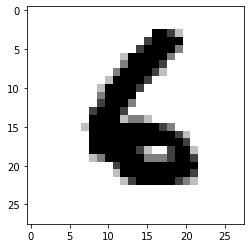

In [98]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


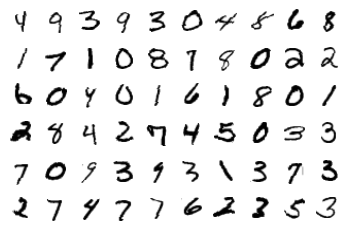

In [99]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [100]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [101]:
# from tqdm.notebook import tqdm

#Not Using scheduler right now
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    # pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    num_loops = 0
    # for batch_idx, (data, target) in enumerate(pbar):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        num_loops +=1
 
    train_loss /= num_loops
    # scheduler.step()
    #scheduler.step(train_loss)
    hist_train_loss.append(train_loss)
    hist_train_acc.append(100. * correct / len(train_loader.dataset))
    print("Training Average loss: {:.6f}, Accuracy = ({:.6f}%)".format(train_loss, 100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    hist_test_loss.append(test_loss)
    hist_test_acc.append(100. * correct / len(test_loader.dataset))

    print('Test set: Average loss: {:.6f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [102]:
dropout_value = 0.0
class Net3_1(nn.Module):
    def __init__(self):
        super(Net3_1, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 7

        # 
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 7

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        #x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

model = Net3_1().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
             ReLU-11            [-1, 8, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,152
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1, 16,

In [103]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 6]

def training_curves():
  plt.subplot(1,2, 1)

  plt.plot(np.array(hist_test_acc))
  plt.plot(np.array(hist_train_acc), 'r')
  plt.legend(["test_acc", "train_acc"])
  plt.title("Accuracy per epoch")

  plt.subplot(1,2,2)
  plt.plot(hist_test_loss)
  plt.plot(hist_train_loss, 'r')
  plt.legend(["test_loss", "train_loss"])
  plt.title("Loss per epoch")

In [104]:
hist_test_loss = []
hist_test_acc = []
hist_train_loss = []
hist_train_acc = []

Epoch:  1
Training Average loss: 0.341473, Accuracy = (90.631667%)
learning rate 0.01
Test set: Average loss: 0.093244, Accuracy: 9739/10000 (97.390000%)

Epoch:  2
Training Average loss: 0.071076, Accuracy = (97.996667%)
learning rate 0.01
Test set: Average loss: 0.047248, Accuracy: 9865/10000 (98.650000%)

Epoch:  3
Training Average loss: 0.054285, Accuracy = (98.420000%)
learning rate 0.01
Test set: Average loss: 0.036900, Accuracy: 9872/10000 (98.720000%)

Epoch:  4
Training Average loss: 0.048132, Accuracy = (98.570000%)
learning rate 0.01
Test set: Average loss: 0.035894, Accuracy: 9888/10000 (98.880000%)

Epoch:  5
Training Average loss: 0.041904, Accuracy = (98.726667%)
learning rate 0.01
Test set: Average loss: 0.032792, Accuracy: 9907/10000 (99.070000%)

Epoch:  6
Training Average loss: 0.039296, Accuracy = (98.748333%)
learning rate 0.01
Test set: Average loss: 0.027697, Accuracy: 9916/10000 (99.160000%)

Epoch:  7
Training Average loss: 0.034788, Accuracy = (98.921667%)
lea

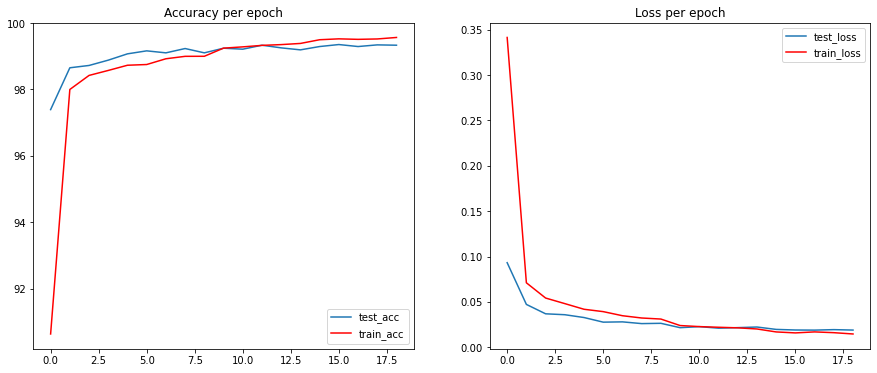

In [105]:
#model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,)

for epoch in range(1, 10):
    print("Epoch: ", epoch)
    train(model, device, train_loader, optimizer, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model, device, test_loader)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
for epoch in range(10, 15):
    print("Epoch: ", epoch)
    train(model, device, train_loader, optimizer, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model, device, test_loader)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
for epoch in range(15, 20):
    print("Epoch: ", epoch)
    train(model, device, train_loader, optimizer, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model, device, test_loader)

training_curves()